In [2]:
!mamba env create --quiet -f environment.yml


CondaValueError: prefix already exists: /srv/conda/envs/alaska-ml



In [ ]:
!conda env create --quiet -f https://raw.githubusercontent.com/Denolle-Lab/seisbench-jupyter/main/environment.yml

In [1]:
import obspy
import obsplus
import pandas as pd
from obspy.clients.fdsn import Client
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests
import seisbench
import seisbench.models as sbm
import dask
import json
import alaska_utils

# Progress bar for dask operations:
from dask.diagnostics import ProgressBar
pbar = dask.diagnostics.ProgressBar()
pbar.register()

#### Download waveforms

In [2]:
# Load master station list
dfS = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet')

# Convert to pandas datetime
dfS['start_date']=pd.to_datetime(dfS['start_date'],infer_datetime_format=True,errors='coerce')
dfS['end_date']=pd.to_datetime(dfS['end_date'],infer_datetime_format=True,errors='coerce')

In [3]:
# Download waveforms

step = 60
t1 = datetime.datetime(2018,5,25,12,35)
t1 = datetime.datetime(2019,5,27,9,52,30)
t2 = t1 + pd.Timedelta(3,'minutes')
time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(step,'seconds')))

@dask.delayed
def loop_times(dfS,t1,step):
    return alaska_utils.retrieve_waveforms(dfS,t1,t1+pd.Timedelta(step,'seconds'),separate=True)

lazy_results = [loop_times(dfS,time,step) for time in time_bins]

In [4]:
results = dask.compute(lazy_results)

[########################################] | 100% Completed | 48.2s
[########################################] | 100% Completed | 48.2s


In [ ]:
# Optional- save to miniseed:
stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
stream.write("alaska_1hour.mseed", format="MSEED") 

stream = obspy.core.stream.read('alaska_1hour.mseed')

In [29]:
# Concat into big list of streams
test = sum(results,[])
stream = []
for t in test:
    stream.extend(t)

#### Denoise

In [30]:
%%time
model = sbm.DeepDenoiser.from_pretrained("original")

CPU times: user 33.4 ms, sys: 2.22 ms, total: 35.7 ms
Wall time: 31.9 ms


In [35]:
%%time
denoise = np.empty([len(stream)],dtype=object)
for i,st in enumerate(stream):
    den = model.annotate(st)
    denoise[i]=den

CPU times: user 49.6 s, sys: 3.3 s, total: 52.9 s
Wall time: 16.6 s


#### Phase pick

In [7]:
model = sbm.EQTransformer.from_pretrained("original")

# EDIT MODEL TO NOT CUT SAMPLES OFF 
# the blinding is applied here: https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/eqtransformer.py#L215

# Note: can we avoid cutting off that last sample too?
model.default_args["blinding"] = (0,1)

In [42]:
%%time
annotation = np.empty([len(denoise)],dtype=object)
pick = np.empty([len(denoise)],dtype=object)
detection = np.empty([len(denoise)],dtype=object)
for i,st in enumerate(denoise):
    at = model.annotate(st)
    # pks, dets = model.classify(st)
    annotation[i]=at; # pick[i]=pks; detection[i]=dets;
    
# Note: still need to figure out why this error is thrown, but it is thrown here:
# https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/base.py#L623
# and here:
# https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/base.py#L548

CPU times: user 48 s, sys: 1.12 s, total: 49.1 s
Wall time: 15.4 s


In [ ]:
# stride = argdict.get("stride", 1)
# Assume stride is 1?
#starts = np.arange(0, block.shape[1] - self.in_samples + 1, stride)

# Sooooo in_samples is less than block.shape[1]-1?

Notes about the "Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty" warning:

For t1 = datetime.datetime(2019,5,27,9,52,30), the warning is thrown on XO.LT12, though only on the first two minutes.
For t1 = datetime.datetime(2018,5,25,12,35), for the first minute, the warning is thrown on XO.LA32. For the next two minutes, it is thrown on XO.LA29.

I caught these by printing out the IDs of the traces for the raw data and the annotated data and visually comparing to see which one is missing- see below. Which is odd... since when you loop through the traces individually and print out their IDs to see which one the error is thrown on, the error is either thrown before or after the missing trace, which makes me think that there's an indexing problem.

It doesn't seem to have anything to do with overlap. The reason those overlaps were appearing was only because we had merged the streams together using this loop:
stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
If you look at the stream produced by this loop, many stations have overlaps between the 60 s traces. It is not what is causing the issue.
The individual streams that the model.annotate() function is performed on do not have overlaps. This can be checked using stream.print_gaps()

I cannot for the life of me find anything that is different about the traces that the warning is thrown on... to be continued! I need to dig into the source code more.


In [80]:
ids = []
for tr in annotation[0]:
    ids.append(tr.id[0:7])
ids.sort()
print(ids)

['AV.KAPH', 'AV.KAPH', 'AV.KAPH', 'AV.KCG.', 'AV.KCG.', 'AV.KCG.', 'AV.PLK3', 'AV.PLK3', 'AV.PLK3', 'TA.Q16K', 'TA.Q16K', 'TA.Q16K', 'XO.KD01', 'XO.KD01', 'XO.KD01', 'XO.KD02', 'XO.KD02', 'XO.KD02', 'XO.KD05', 'XO.KD05', 'XO.KD05', 'XO.KD12', 'XO.KD12', 'XO.KD12', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KT06', 'XO.KT06', 'XO.KT06', 'XO.KT08', 'XO.KT08', 'XO.KT08', 'XO.KT10', 'XO.KT10', 'XO.KT10', 'XO.LA21', 'XO.LA21', 'XO.LA21', 'XO.LA23', 'XO.LA23', 'XO.LA23', 'XO.LA25', 'XO.LA25', 'XO.LA25', 'XO.LA26', 'XO.LA26', 'XO.LA26', 'XO.LA28', 'XO.LA28', 'XO.LA28', 'XO.LA29', 'XO.LA29', 'XO.LA29', 'XO.LA30', 'XO.LA30', 'XO.LA30', 'XO.LA33', 'XO.LA33', 'XO.LA33', 'XO.LA34', 'XO.LA34', 'XO.LA34', 'XO.LD35', 'XO.LD35', 'XO.LD35', 'XO.LD36', 'XO.LD36', 'XO.LD36', 'XO.LD41', 'XO.LD41', 'XO.LD41', 'XO.LD44', 'XO.LD44', 'XO.LD44', 'XO.LD45'

In [81]:
ids = []
for tr in results[0][0]:
    ids.append(tr.id[0:7])
ids.sort()
print(ids)

['AV.KAPH', 'AV.KAPH', 'AV.KAPH', 'AV.KCG.', 'AV.KCG.', 'AV.KCG.', 'AV.PLK3', 'AV.PLK3', 'AV.PLK3', 'TA.Q16K', 'TA.Q16K', 'TA.Q16K', 'XO.KD01', 'XO.KD01', 'XO.KD01', 'XO.KD02', 'XO.KD02', 'XO.KD02', 'XO.KD05', 'XO.KD05', 'XO.KD05', 'XO.KD12', 'XO.KD12', 'XO.KD12', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KT06', 'XO.KT06', 'XO.KT06', 'XO.KT08', 'XO.KT08', 'XO.KT08', 'XO.KT10', 'XO.KT10', 'XO.KT10', 'XO.LA21', 'XO.LA21', 'XO.LA21', 'XO.LA23', 'XO.LA23', 'XO.LA23', 'XO.LA25', 'XO.LA25', 'XO.LA25', 'XO.LA26', 'XO.LA26', 'XO.LA26', 'XO.LA28', 'XO.LA28', 'XO.LA28', 'XO.LA29', 'XO.LA29', 'XO.LA29', 'XO.LA30', 'XO.LA30', 'XO.LA30', 'XO.LA32', 'XO.LA32', 'XO.LA32', 'XO.LA33', 'XO.LA33', 'XO.LA33', 'XO.LA34', 'XO.LA34', 'XO.LA34', 'XO.LD35', 'XO.LD35', 'XO.LD35', 'XO.LD36', 'XO.LD36', 'XO.LD36', 'XO.LD41', 'XO.LD41', 'XO.LD41', 'XO.LD44'

In [10]:
# smash everything into one big array


stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
denoised = obspy.core.stream.Stream()
for st in denoise:
    denoised.extend(st)
annotations = obspy.core.stream.Stream()
for st in annotation:
    annotations.extend(st)
picks = sum(pick,[])

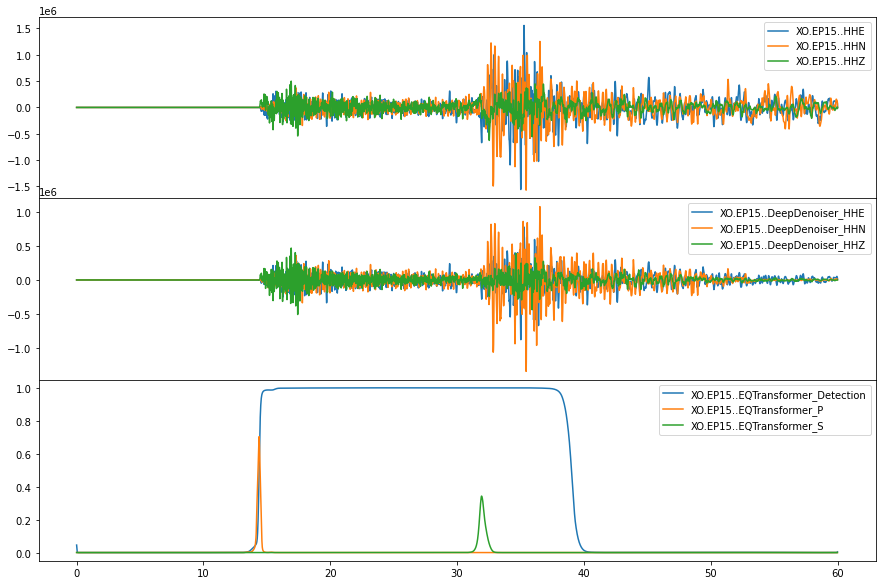

In [11]:
# GUT CHECK

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - denoised[0].stats.starttime
for i in [12,13,14]: #LT03
    axs[0].plot(stream[i+2].times(), stream[i+2].data, label=stream[i+2].id) #NOTICE: indices are off
    axs[1].plot(denoised[i].times(), denoised[i].data, label=denoised[i].id)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[2].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].id)

axs[0].legend()
axs[1].legend()
axs[2].legend()

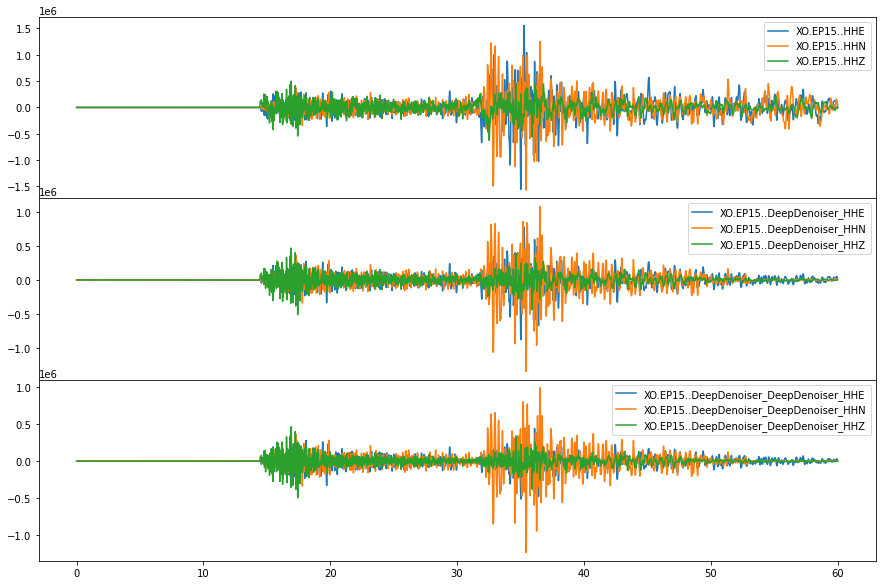

In [50]:
# GUT CHECK

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotation[0][0].stats.starttime - denoise[0][0].stats.starttime
i=5
for j in [0,1,2]:
    axs[0].plot(stream[i][j].times(), stream[i][j].data, label=stream[i][j].id) 
    axs[1].plot(denoise[i][j].times(), denoise[i][j].data, label=denoise[i][j].id)
    axs[2].plot(annotation[i][j].times() + offset, annotation[i][j].data, label=annotation[i][j].id)

axs[0].legend()
axs[1].legend()
axs[2].legend()

#### Convert picks to be GAMMA-compatible

In [248]:
# If we were to just use the picks that we get from the model.classify() function, we could just do this- 
# but, they are missing amplitude information

gamma_picks = []
for pick in picks:
    pdict = {'id':pick.trace_id,'timestamp':pick.peak_time,'prob':pick.peak_value,'type':pick.phase}
    gamma_picks.append(pdict)

In [12]:
# Prep data metadata to match to annotations

data_ids = []
data_starttimes = []
data_endtimes = []
data_npts = []
for tr in stream:
    data_ids.append(tr.stats.network + '..' + tr.stats.station + '.')
    data_starttimes.append(tr.stats.starttime)
    data_endtimes.append(tr.stats.endtime)
    data_npts.append(tr.stats.npts)
    

Note: some annotated streams are 5999 samples, others are 6000

In [201]:
# Good start on matching but more work to be done

In [13]:
# Reshape data to extract GAMMA picks using postprocess functions
# They need to be in 4-D arrays


preds = np.empty([int(len(annotations)/3),6000,1,3])
station_ids = []
t0 = []
match_idx = []
for i in range(int(len(annotations)/3)):
    d_idx = (i*3)
    p_idx = (i*3) + 1
    s_idx = (i*3) + 2
    
    # For short traces:
    if annotations[d_idx].stats.npts < preds.shape[1]:
        preds[i,:,0,0] = np.append(annotations[d_idx].data,[0])
        preds[i,:,0,1] = np.append(annotations[p_idx].data,[0])
        preds[i,:,0,2] = np.append(annotations[s_idx].data,[0])
    # For traces of correct length:
    else:
        preds[i,:,0,0] = annotations[d_idx].data
        preds[i,:,0,1] = annotations[p_idx].data
        preds[i,:,0,2] = annotations[s_idx].data
    
    station_id = annotations[d_idx].stats.network + '..' + annotations[d_idx].stats.station + '.'
    station_ids.append(station_id)
    t0.append(str(annotations[d_idx].stats.starttime))
    
    # Match to the original data
    id_match = [j for j,id in enumerate(data_ids) if id == station_id]
    time_match = [j for j,id in enumerate(data_starttimes) if id == annotations[p_idx].stats.starttime]
    match_idx.append(set(time_match).intersection(id_match))

In [ ]:
# NEW VERSION- after rewriting with split traces

import postprocess

preds = np.empty([int(len(annotation)),6000,1,3])
station_ids = []
t0 = []
match_idx = []
for i in range(int(len(annotation))):
    
    # For short traces:
    if annotations[i][0].stats.npts < preds.shape[1]:
        preds[0,:,0,0] = np.append(annotation[i][0].data,[0])
        preds[0,:,0,1] = np.append(annotation[i][1].data,[0])
        preds[0,:,0,2] = np.append(annotation[i][2].data,[0])
    # For traces of correct length:
    else:
        preds[0,:,0,0] = annotation[i][0].data
        preds[0,:,0,1] = annotation[i][1].data
        preds[0,:,0,2] = annotation[i][2].data
    
    station_id = annotation[i][0].stats.network + '..' + annotation[i][0].stats.station + '.'
    station_ids.append(station_id)
    t0.append(str(annotation[i][0].stats.starttime))
    
    picks = postprocess.extract_picks(preds,station_ids = station_ids,fnames = station_ids,t0=t0)
    
    # TO-DO: now call to original data using the same i index to get amplitudes
    if picks:
        amps = postprocess.extract_amplitude(picks,test)
        
    # Then, if the pick isn't empty, make a GAMMA-style pick dictionary and save that!

It would be great to have the channel names saved in the annotation trace id. Otherwise it will be difficult to correctly match the annotations to the original data.

NOTE- I rewrote this to overcome this problem by saving separate streams for each station/time chunk, to keep the stations that have multiple channel sets separate.